In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns=200
pd.options.display.max_colwidth=200

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
deleteFeatures = False
useBisRow = 10000
eps = 0.5
min_samples = 5

In [85]:
dt =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/UNSW-NB15_1.csv', header = None, dtype={1: 'object'})
dt.columns = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/NUSW-NB15_features.csv',encoding='cp1252').Name

In [86]:
data = dt [0:useBisRow]
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/anomaly_labels.csv')
labels.Label = [-x if x == 1 else 0 for x in labels.Label ]
anomaly_labels = labels.Label[0:useBisRow]

In [87]:
Counter(data["Label"]).keys()

dict_keys([0, 1])

In [88]:
Counter(data["Label"]).values()

dict_values([9327, 673])

In [89]:
data['service']= np.where(data['service'] == '-', 'None', data['service'])
data['state']= np.where(data['state'] == 'no', 'None', data['state'])
data['is_sm_ips_ports'] = data['is_sm_ips_ports'].astype(bool)
data['is_ftp_login'] = data['is_ftp_login'].astype(bool)
data['ct_state_ttl'] = data['ct_state_ttl'].astype('category')

In [157]:
if deleteFeatures:
  selected_df = data[['service', 'sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst' ]]
  num_cols = selected_df.drop(columns = 'service')
  scaler = MinMaxScaler()
  num_cols = scaler.fit_transform(num_cols)
  num_cols = pd.DataFrame(num_cols)
  num_cols.columns = ['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 
                            'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst']
  cat_cols = selected_df['service']
  labelencoder = LabelEncoder()
  le_value = labelencoder.fit_transform(cat_cols)
  cat_cols = le_value
  onehotcols = pd.DataFrame(cat_cols, columns = ['service'])
  encoder= OneHotEncoder()
  onehotcols = encoder.fit_transform(onehotcols).toarray() 
  onehotdf = pd.DataFrame(onehotcols)
  processed_data = pd.concat([onehotdf, num_cols ], axis =1)

else:
  num_cols=data.select_dtypes(include='number')
  num_cols = num_cols.drop(columns='Label', axis=1)
  scaler = MinMaxScaler()
  num_data = scaler.fit_transform(num_cols)  
  num_data = pd.DataFrame(num_data)
  num_data.columns=num_cols.columns

  cat_cols = data.select_dtypes(exclude='number')
  cat_data=cat_cols.drop(['srcip','dstip','sport','dsport', 'attack_cat'], axis=1)
  cat_data['is_ftp_login']=cat_data['is_ftp_login'].astype('category')
  cat_data['is_sm_ips_ports']=cat_data['is_sm_ips_ports'].astype('category')
  data_dummies = pd.get_dummies(cat_data, drop_first=True)
  processed_data = pd.concat([data_dummies, num_data ], axis =1)

data_model_input = processed_data
data_model_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   proto_icmp            10000 non-null  uint8  
 1   proto_ospf            10000 non-null  uint8  
 2   proto_tcp             10000 non-null  uint8  
 3   proto_udp             10000 non-null  uint8  
 4   state_ECO             10000 non-null  uint8  
 5   state_FIN             10000 non-null  uint8  
 6   state_INT             10000 non-null  uint8  
 7   state_REQ             10000 non-null  uint8  
 8   state_RST             10000 non-null  uint8  
 9   state_URH             10000 non-null  uint8  
 10  service_dns           10000 non-null  uint8  
 11  service_ftp           10000 non-null  uint8  
 12  service_ftp-data      10000 non-null  uint8  
 13  service_http          10000 non-null  uint8  
 14  service_pop3          10000 non-null  uint8  
 15  service_smtp        

In [91]:
max_calinski = 0

# Full Model¶

In [92]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
# Defining the agglomerative clustering
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

In [93]:
# Fit model
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [94]:
Counter(cluster_preds).keys()

dict_keys([0, 1, -1, 2, 3, 4, 5, 19, 6, 7, 8, 9, 10, 11, 14, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [95]:
Counter(cluster_preds).values()

dict_values([1602, 671, 274, 81, 66, 120, 266, 6, 12, 735, 4301, 617, 34, 9, 4, 55, 348, 427, 145, 13, 24, 24, 45, 8, 17, 43, 8, 20, 6, 6, 7, 6])

In [96]:
Counter(anomaly_labels).keys()

dict_keys([0, -1])

In [97]:
Counter(anomaly_labels).values()

dict_values([9327, 673])

In [98]:
anom_preds = np.where(cluster_preds == -1, -1, 0)

In [99]:
Counter(anom_preds).keys()

dict_keys([0, -1])

In [100]:
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,111,562
0,163,9164


In [101]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.16
Precision: 0.41


In [102]:
from sklearn.metrics import (davies_bouldin_score, silhouette_score, calinski_harabasz_score)
## ratio between the within-cluster dispersion and the between-cluster dispersion.
## higher Calinski-Harabasz score relates to a model with better defined clusters.
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [104]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [106]:
##  average similarity measure of each cluster with its most similar cluster,
## The minimum score is zero, with lower values indicating better clustering.
davies_bouldin_score(data_model_input, anom_preds)

4.058470651514719

# Model with Selected Features¶

In [107]:
service_dummy = pd.get_dummies(data['service'], drop_first=True)
selected_df = pd.concat([num_data[['sttl', 'sbytes', 'smeansz', 'ct_dst_sport_ltm']], service_dummy], axis=1)

In [108]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [109]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,111,562
0,163,9164


In [114]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [116]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [117]:
davies_bouldin_score(data_model_input, anom_preds)

4.058470651514719

# Model 1

In [118]:
data_model_input = data[['sbytes', 'sttl']].copy()

In [119]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [120]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,436,237
0,161,9166


In [121]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [122]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

205.06907268528695


In [123]:
davies_bouldin_score(data_model_input, anom_preds)

2.572705574784958

# Model 2

In [124]:
data_model_input = data[['sbytes', 'sttl', 'dttl']].copy()

In [125]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [126]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,438,235
0,161,9166


In [127]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [128]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [129]:
davies_bouldin_score(data_model_input, anom_preds)

2.581657487139407

# Model 3

In [130]:
data_model_input = data[['sbytes', 'sttl','tcprtt','synack']].copy()

In [131]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [132]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,436,237
0,161,9166


In [133]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [134]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

205.06907270614846


In [135]:
davies_bouldin_score(data_model_input, anom_preds)

2.572705574778056

# Model 4

In [136]:
data_model_input = data[['sbytes', 'sttl','tcprtt','synack', 'ackdat']].copy()

In [137]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [138]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,436,237
0,161,9166


In [139]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [140]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

205.0690727127294


In [141]:
davies_bouldin_score(data_model_input, anom_preds)

2.5727055747575744

# Model 5

In [142]:
data_model_input = data[['sbytes', 'sttl','tcprtt','synack', 'ackdat', 'Sload']].copy()

In [143]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [144]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,630,43
0,8334,993


In [145]:
if len(Counter(cluster_preds).keys()) > 1:
  calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [146]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [147]:
if len(Counter(cluster_preds).keys()) > 1:
  davies_bouldin_score(data_model_input, anom_preds)

# Hyperparameter Tuning

In [149]:
best_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sbytes  10000 non-null  int64  
 1   sttl    10000 non-null  int64  
 2   tcprtt  10000 non-null  float64
 3   synack  10000 non-null  float64
 4   ackdat  10000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


In [151]:
params = {'eps': [0.3, 0.5, 1, ],
         'min_samples': [10, 30, 50, 100]}

score_table = pd.DataFrame(columns=['Epsilon', 'Min Sample Size',
                                    'Calinski Harabasz Score', 'Davies Bouldin Score', 'Num Anomalies Found'])
max_calinski = 0
best_eps = 0.5
best_min_samples = 10
data_model_input = best_data

for eps in params['eps']:
    for min_samples in params['min_samples']:
      try:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_preds = dbscan_model.fit_predict(data_model_input)  
        print(cluster_preds.tolist().count(-1))
        anom_preds = np.where(cluster_preds == -1, -1, 0)     
        calinski = calinski_harabasz_score(data_model_input, anom_preds)                  
        if calinski > max_calinski:
          max_calinski = calinski
          best_eps = eps
          best_min_samples = min_samples
        davies = davies_bouldin_score(data_model_input, anom_preds)
        score_table=score_table.append({'Epsilon':eps, 
                                      'Min Sample Size':min_samples,
                                      'Calinski Harabasz Score':calinski, 
                                      'Davies Bouldin Score':davies,
                                      'Num Anomalies Found':cluster_preds.tolist().count(-1)}, 
                                      ignore_index=True)
        score_table
      except:
        print("Exception")
        
display(score_table)

745
1489
1939
2836
745
1489
1939
2836
745
1489
1939
2836


,Epsilon,Min Sample Size,Calinski Harabasz Score,Davies Bouldin Score,Num Anomalies Found
0,0.3,10.0,224.595732,2.461019,745.0
1,0.3,30.0,161.862946,2.992818,1489.0
2,0.3,50.0,225.040729,2.717836,1939.0
3,0.3,100.0,257.882526,2.597300,2836.0
4,0.5,10.0,224.595732,2.461019,745.0
5,0.5,30.0,161.862946,2.992818,1489.0
6,0.5,50.0,225.040729,2.717836,1939.0
7,0.5,100.0,257.882526,2.597300,2836.0
8,1.0,10.0,224.595732,2.461019,745.0
9,1.0,30.0,161.862946,2.992818,1489.0


### Best Model

In [152]:
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,673,0
0,2163,7164


In [153]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 1.00
Precision: 0.24


In [154]:
calinski_harabasz_score(data_model_input, anom_preds)

257.88252566950337

In [155]:
davies_bouldin_score(data_model_input, anom_preds)

2.5972995019957987

### Results with PCA

In [158]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(processed_data)

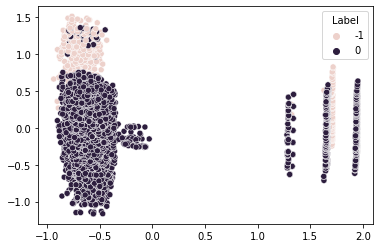

In [159]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anomaly_labels)

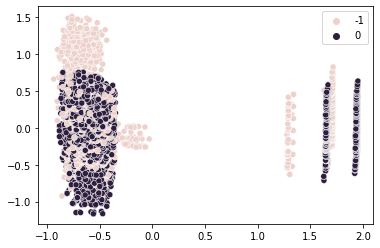

In [160]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anom_preds)

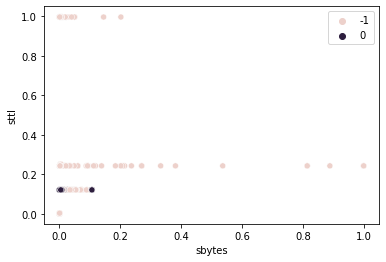

In [161]:
sns.scatterplot(processed_data.sbytes, processed_data.sttl, hue=anom_preds)